<a href="https://colab.research.google.com/github/Nolanole/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/Josh_Mancuso_Thursday_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASSIGNMENT

**Train Random Forest and Gradient Boosting models**, on the Bank Marketing dataset. (Or another dataset of your choice, not used during this lesson.) You may use any Python libraries for Gradient Boosting.

Then, you have many options!

#### Keep improving your model
- **Try new categorical encodings.**
- Explore and visualize your data. 
- Wrangle [bad data](https://github.com/Quartz/bad-data-guide), outliers, and missing values.
- Try engineering more features. You can transform, bin, and combine features. 
- Try selecting fewer features.

#### Follow the links — learn by reading & doing
- Links at the top of this notebook
- Links in previous notebooks
- Extra notebook for today, about **"monotonic constraints"** and "early stopping" with xgboost

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/


In [5]:
!pip install kaggle

In [6]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 45.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 6.96MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.77MB/s]


In [58]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


In [0]:
# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [0]:
drop_cols = ['PassengerId', 'Ticket']
train = pd.read_csv('train.csv').drop(columns=drop_cols)
#test = pd.read_csv('test.csv').drop(columns=drop_cols)

#fillna for 2 missing rows of embarked, using most frequent embarkation:#fillna 
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

#impute missing values for Age and 1 missing fare (in test):
mean_age = train.Age.mean()
mean_fare = train.Fare.mean()
train['Age'].fillna(mean_age, inplace=True)
#test['Fare'].fillna(mean_fare, inplace=True)

In [0]:
#extract the deck from the Cabin feature, then drop Cabin: (copy pasted from a TDS article)

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train]#, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    #dataset['deck'] = dataset['deck'].map(deck)
    dataset['deck'] = dataset['deck'].fillna(0)
    #dataset['deck'] = dataset['deck'].astype(int)
# we can now drop the cabin feature
train = train.drop(['Cabin'], axis=1)
#test = test.drop(['Cabin'], axis=1)

In [0]:
def make_features(X):
    X = X.copy()
    X['adult_male'] = (X['Sex'] == 'male') & (X['Age'] >= 16)
    X['adult_female'] = (X['Sex'] == 'female') & (X['Age'] >= 16)
    X['child'] = (X['Age'] < 16)
    X['alone'] = (X['SibSp'] == 0) & (X['Parch'] == 0)
    X['title'] = X['Name'].str.split(',').str[1].str.split('.').str[0].str.lstrip()
    X['age_times_class'] = X['Age']*(X['Pclass'])
    X['num_companions'] = X['SibSp'] + X['Parch']
    X['group_fare'] = X['Fare']*(X['num_companions']+1)
    X['mother_w_child'] = (X['Sex'] == 'female') & (X['Age'] >= 18) & (X['Parch'] > 0)
    X.drop(columns='Name', inplace=True)
    return X
  
train = make_features(train)
#test  = make_features(test)

In [0]:
def bin_cols(X):
  X = X.copy()
  for i in range(len(X)): 
    if (X.at[i, 'title'] == 'Mr') or (X.at[i, 'title'] == 'Miss') or (X.at[i, 'title'] == 'Mrs'):
      pass
    else:
      X.at[i, 'title'] = 'Other'
    if X.at[i, 'num_companions'] > 3:
      X.at[i, 'num_companions'] = 4
  return X

train = bin_cols(train)
#test = bin_cols(test)

In [0]:
target = 'Survived'
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare',
       'Embarked', 'deck', 'adult_male', 'adult_female', 'child', 'alone',
       'title', 'age_times_class', 'num_companions', 'group_fare', 'Parch', 'mother_w_child']

preprocessor = make_pipeline(ce.OrdinalEncoder())
X = preprocessor.fit_transform(train[features])
X = pd.DataFrame(X, columns=features)
y = train[target]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
forest = RandomForestClassifier(max_depth=5, n_estimators=10)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)[:,1]


r2_test = forest.score(X_test, y_test)
print('Test R2 score: ' + str(r2_test))
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy ' + str(accuracy))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Roc_Auc score: ' + str(roc_auc))

Test R2 score: 0.8268156424581006
Accuracy 0.8268156424581006
Roc_Auc score: 0.9042471042471043


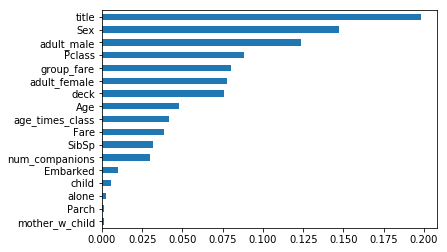

In [91]:
importances = pd.Series(forest.feature_importances_, X_train.columns)
importances.sort_values().plot.barh()
plt.show()

In [0]:
#try a bunch of max_depths and n_estimators

max_depths = [2,3,5,8, None]
estimators = [10, 100, 500]
min_leaves = [1, 2, 4, 8]
min_samples = [2, 5, 10]

#function to run a a series of RandomForestClassifiers w/ diff parameters
#Output scores to pandas dataframe:

def test_forest(X, y, max_depths, estimators, min_leaves, min_samples):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  cols = ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split', 
          'test_R2', 'test_accuracy', 'ROC-AUC']
  rows = []
  for md in max_depths:
    for ne in estimators:
      for msl in min_leaves:
        for mss in min_samples:
          forest = RandomForestClassifier(max_depth=md, n_estimators=ne, 
                                          min_samples_leaf = msl, 
                                          min_samples_split = mss, 
                                          n_jobs=-1, random_state=42)
          forest.fit(X_train, y_train)
          y_pred = forest.predict(X_test)
          y_pred_proba = forest.predict_proba(X_test)[:,1]
          r2_test = forest.score(X_test, y_test)
          accuracy = accuracy_score(y_pred, y_test)
          roc_auc = roc_auc_score(y_test, y_pred_proba)
          row = [md, ne, msl, mss, r2_test, accuracy, roc_auc]
          rows.append(row)
  df = pd.DataFrame(data=rows, columns=cols)
  return df

In [0]:
target = 'Survived'
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare',
       'Embarked', 'deck', 'adult_male', 'adult_female', 'child', 'alone',
       'title', 'age_times_class', 'num_companions', 'group_fare']

preprocessor = make_pipeline(ce.OrdinalEncoder())
X = preprocessor.fit_transform(train[features])
X = pd.DataFrame(X, columns=features)
y = train[target]

rf_df = test_forest(X, y, max_depths, estimators)

In [114]:
rf_df.head(10)

,max_depth,n_estimators,min_samples_leaf,min_samples_split,test_R2,test_accuracy,ROC-AUC
0,2.0,10,2,2,0.798883,0.798883,0.876448
1,2.0,10,2,5,0.815642,0.815642,0.888546
2,2.0,10,2,10,0.798883,0.798883,0.876577
3,2.0,10,4,2,0.798883,0.798883,0.870849
4,2.0,10,4,5,0.798883,0.798883,0.878378
5,2.0,10,4,10,0.787709,0.787709,0.880051
6,2.0,10,8,2,0.832402,0.832402,0.882239
7,2.0,10,8,5,0.770950,0.770950,0.864479
8,2.0,10,8,10,0.787709,0.787709,0.862806
9,2.0,100,2,2,0.798883,0.798883,0.877413


In [115]:
rf_df.describe()

,max_depth,n_estimators,min_samples_leaf,min_samples_split,test_R2,test_accuracy,ROC-AUC
count,108.00000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,4.50000,203.333333,4.666667,5.666667,0.815229,0.815229,0.891855
std,2.30197,213.761619,2.503729,3.312122,0.013541,0.013541,0.011366
min,2.00000,10.000000,2.000000,2.000000,0.770950,0.770950,0.862806
25%,2.75000,10.000000,2.000000,2.000000,0.810056,0.810056,0.882625
50%,4.00000,100.000000,4.000000,5.000000,0.815642,0.815642,0.892793
75%,5.75000,500.000000,8.000000,10.000000,0.821229,0.821229,0.901737
max,8.00000,500.000000,8.000000,10.000000,0.854749,0.854749,0.911969


In [117]:
rf_df[rf_df.test_accuracy > .84]

,max_depth,n_estimators,min_samples_leaf,min_samples_split,test_R2,test_accuracy,ROC-AUC
108,NaN,10,2,2,0.854749,0.854749,0.899807
109,NaN,10,2,5,0.854749,0.854749,0.909588
117,NaN,100,2,2,0.843575,0.843575,0.905727


In [0]:
#similar function to test w/ XGB:

def test_XGB(X, y, max_depths, estimators):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  cols = ['max_depth', 'n_estimators', 'test_R2', 'test_accuracy', 'ROC-AUC']
  rows = []
  for md in max_depths:
    for ne in estimators:
      xgb = XGBClassifier(max_depth=md, n_estimators=ne,  
                                          n_jobs=-1, random_state=42)
      forest.fit(X_train, y_train)
      y_pred = forest.predict(X_test)
      y_pred_proba = forest.predict_proba(X_test)[:,1]
      r2_test = forest.score(X_test, y_test)
      accuracy = accuracy_score(y_pred, y_test)
      roc_auc = roc_auc_score(y_test, y_pred_proba)
      row = [md, ne, r2_test, accuracy, roc_auc]
      rows.append(row)
  df = pd.DataFrame(data=rows, columns=cols)
  return df

In [0]:
max_depths = [2,3,5,10]
estimators = [10,100,500]

xgb_df = test_XGB(X,y,max_depths, estimators)

In [124]:
xgb_df.head(10)

,max_depth,n_estimators,test_R2,test_accuracy,ROC-AUC
0,2,10,0.815642,0.815642,0.891313
1,2,100,0.804469,0.804469,0.901673
2,2,500,0.832402,0.832402,0.886680
3,3,10,0.821229,0.821229,0.885586
4,3,100,0.810056,0.810056,0.869048
5,3,500,0.810056,0.810056,0.879408
6,5,10,0.810056,0.810056,0.891892
7,5,100,0.798883,0.798883,0.895817
8,5,500,0.815642,0.815642,0.892664
9,10,10,0.826816,0.826816,0.890154


In [125]:
xgb_df.describe()

,max_depth,n_estimators,test_R2,test_accuracy,ROC-AUC
count,12.00000,12.000000,12.000000,12.000000,12.000000
mean,5.00000,203.333333,0.813780,0.813780,0.888723
std,3.21926,222.438279,0.009328,0.009328,0.008278
min,2.00000,10.000000,0.798883,0.798883,0.869048
25%,2.75000,10.000000,0.810056,0.810056,0.886406
50%,4.00000,100.000000,0.810056,0.810056,0.890734
75%,6.25000,500.000000,0.817039,0.817039,0.892423
max,10.00000,500.000000,0.832402,0.832402,0.901673


In [127]:
xgb_df[xgb_df.test_accuracy>.82]

,max_depth,n_estimators,test_R2,test_accuracy,ROC-AUC
2,2,500,0.832402,0.832402,0.886680
3,3,10,0.821229,0.821229,0.885586
9,10,10,0.826816,0.826816,0.890154
